In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt

## Loading Data from simulation results

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_fixed_dt.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho_fixed_dt.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T_fixed_dt.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [3]:
# Training data
X = fl_pressure

In [4]:
pod = ROM(rom="pod")
pod.decompose(X, alg="svd",)

In [5]:
rank = 4
rec_X = pod.approximate(rank)

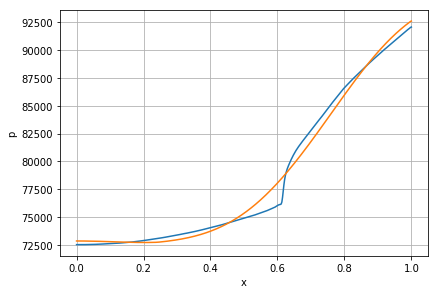

In [6]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , nt-1000]);
plt.plot(domain, rec_X[: , nt -1000]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

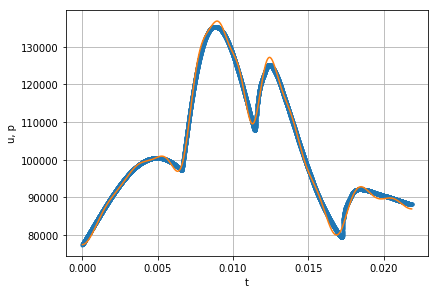

In [7]:
plt.plot(t, X[-1, :], '.');
plt.plot(t, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

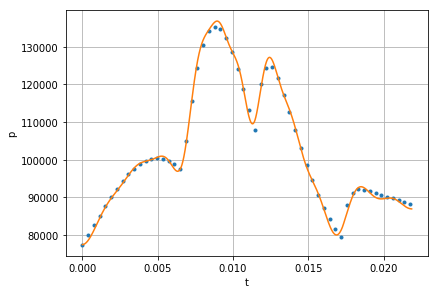

In [8]:
plt.plot(t[::120], X[-1, ::120], '.');
plt.plot(t, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**DMD reduction on velocity**

In [29]:
# Time truncation ------------------
cut = 84
## Parameters ----------------
rank = 0
dt = 3.69e-06

# Training data
X = np.concatenate(( fl_rho_e[:, :-1:cut], ))
Y = np.concatenate(( fl_rho_e[:, 1::cut],))
# X = fl_velocity[:, :-1:cut]
# Y = fl_velocity[:, 1::cut]

tt = t[::cut]
dt = (tt[1::] - tt[:-1]).mean()

In [30]:
dmd = ROM("dmd")
dmd.decompose(X, Y, dt = dt, rank = rank, sorting="abs")

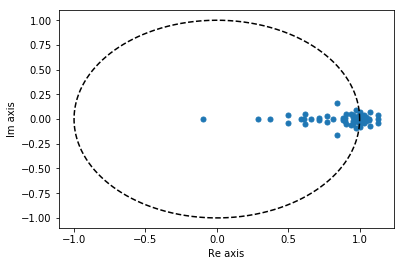

In [31]:
plt.plot(np.real(dmd.lambd), np.imag(dmd.lambd), '.', markersize = 10);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

## Reconstructing X

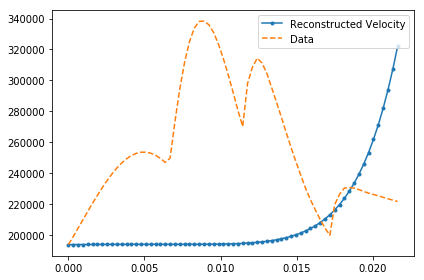

In [32]:
predicted_X = np.real(dmd.dmd_predict(tt, X[:, 0]))

plt.plot(tt, predicted_X[-1, :], '.-', label = "Reconstructed Velocity")
plt.plot(tt, X[-1, :], '--', label = "Data");
plt.legend();
plt.tight_layout();